In [1]:
from urllib.request import HTTPCookieProcessor, urlopen
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import astropy.coordinates as coord
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.io import ascii
import matplotlib.cm as cm
import astropy.units as u
from cycler import cycler
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import glob
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
month = 12
day_range = np.arange(1,32)
year = 2021
list_months = ['January','February', 'March','April','May','June','July','August ','September','October',
'November','December']

In [3]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
    
def parseSubtables(searchQueryRoot, objectDict):
    if searchQueryRoot is not None:
        for row in searchQueryRoot.find("./subtable"):
            name = row.find("./label").text.upper()
            nUniq = int(row.find("./nb_events").text)
            nEvents = int(row.find("./nb_events").text)
            if name not in objectDict.keys():
                objectDict[name] = (0,0)            
            a = objectDict[name]
            objectDict[name] = (a[0]+ nEvents, a[1] + nUniq)
            
            
def transformation_for_objects(obj_coor_data_ra,obj_coor_data_dec):
    ra_objects = obj_coor_data_ra.values
    dec_objects = obj_coor_data_dec.values
    for i in range(len(dec_objects)):
        ra_objects[i] = str(ra_objects[i]) + ' hours'
    for i in range(len(dec_objects)):
        dec_objects[i] = str(dec_objects[i]) + ' degrees'
    dec_obj = coord.Angle(dec_objects)
    ra_obj = coord.Angle(ra_objects)
    ra_obj = ra_obj.wrap_at(180*u.degree)
    return dec_obj,ra_obj

def point_features(num):
    if num<110:
        alpha = 1
        s= num*2
        label = str(int(num)-10) +' - ' +str(num)
        return alpha,s, label
    else:
        alpha = 0.9
        s=num*1.5
        label = str(int(num)-50) +' - ' +str(num)
        return alpha,s, label

def interval(n):
    if n < 100:
        arr = np.arange(0,110,10)
        for i in range(len(arr)):
            if n>=arr[i] and n<arr[i+1]:
                 return arr[i+1]       
    if n > 100:
        arr = np.arange(100,2000,50)
        for i in range(len(arr)):
            if n>=arr[i] and n<arr[i+1]:
                 return arr[i+1]                 
        
def get_color(data):
    col = []
    for c in data['Number_of_searches'].unique():
        col.append(interval(c))
    col = list(set(col))
    N = len(col)
    return col,N

This cell contained code to obtain data for the plot. This code was deleted because it contains sensitive information. The result of this cell is a pandas data frame of searched objects -  **search_data** 

In [ ]:
#DOWNLOAD DATA

In [5]:
def search_by_object(search_data):
    """Search object coordinates in Simbad"""
    failed_obj = []
    data_simbad = {}
    data_unique = {}
    sorted_objects = pd.DataFrame()
    coordinates_object_data = pd.DataFrame()
    for i in range(len(search_data)):
        coor = search_data.iloc[i]['Object'].replace('\t',' ').replace(',',' ').split(' ')
        while '' in coor:
            coor.remove('')
        if not all(isfloat(j) for j in coor):
                astro_object = search_data.iloc[i]['Object']
                try:
                    result = Simbad.query_object(astro_object)
                    if result['RA'][0] !='' or result['DEC'][0]!='': #this condition is there because of object ORI IA which is in simbad but has no coordinates
                        data_simbad['RA'] = result['RA'][0]
                        data_simbad['DEC'] = result['DEC'][0]
                        data_simbad['Object'] = astro_object
                        data_simbad['Number of searches'] = search_data.iloc[i]['Number of searches']
                        df = pd.DataFrame([data_simbad], index = [i])
                        coordinates_object_data = coordinates_object_data.append(df)                    
                except:
                    failed_obj.append(astro_object)
    coordinates_object_data = coordinates_object_data.dropna()  
    coordinates_object_data['coor']= coordinates_object_data['RA']+coordinates_object_data['DEC']
    unique = coordinates_object_data['coor'].unique()
    #this part of the code is looking for unique coordinates
    #in case there are same object named differently M1/Crab Nebula
    for obj in unique:
        row = coordinates_object_data.loc[coordinates_object_data['coor']==obj]
        data_unique['Object'] = row['Object'].iloc[0]
        data_unique['Number_of_searches'] =  row['Number of searches'].sum()
        data_unique['RA'] =  row['RA'].iloc[0]
        data_unique['DEC'] =  row['DEC'].iloc[0]
        df = pd.DataFrame([data_unique], index = [obj])
        sorted_objects = sorted_objects.append(df)  
    sorted_objects = sorted_objects.sort_values('Number_of_searches')
    sorted_objects = sorted_objects.dropna()
    return sorted_objects

**Table example of part of the data**
![alt text](table_example.png)

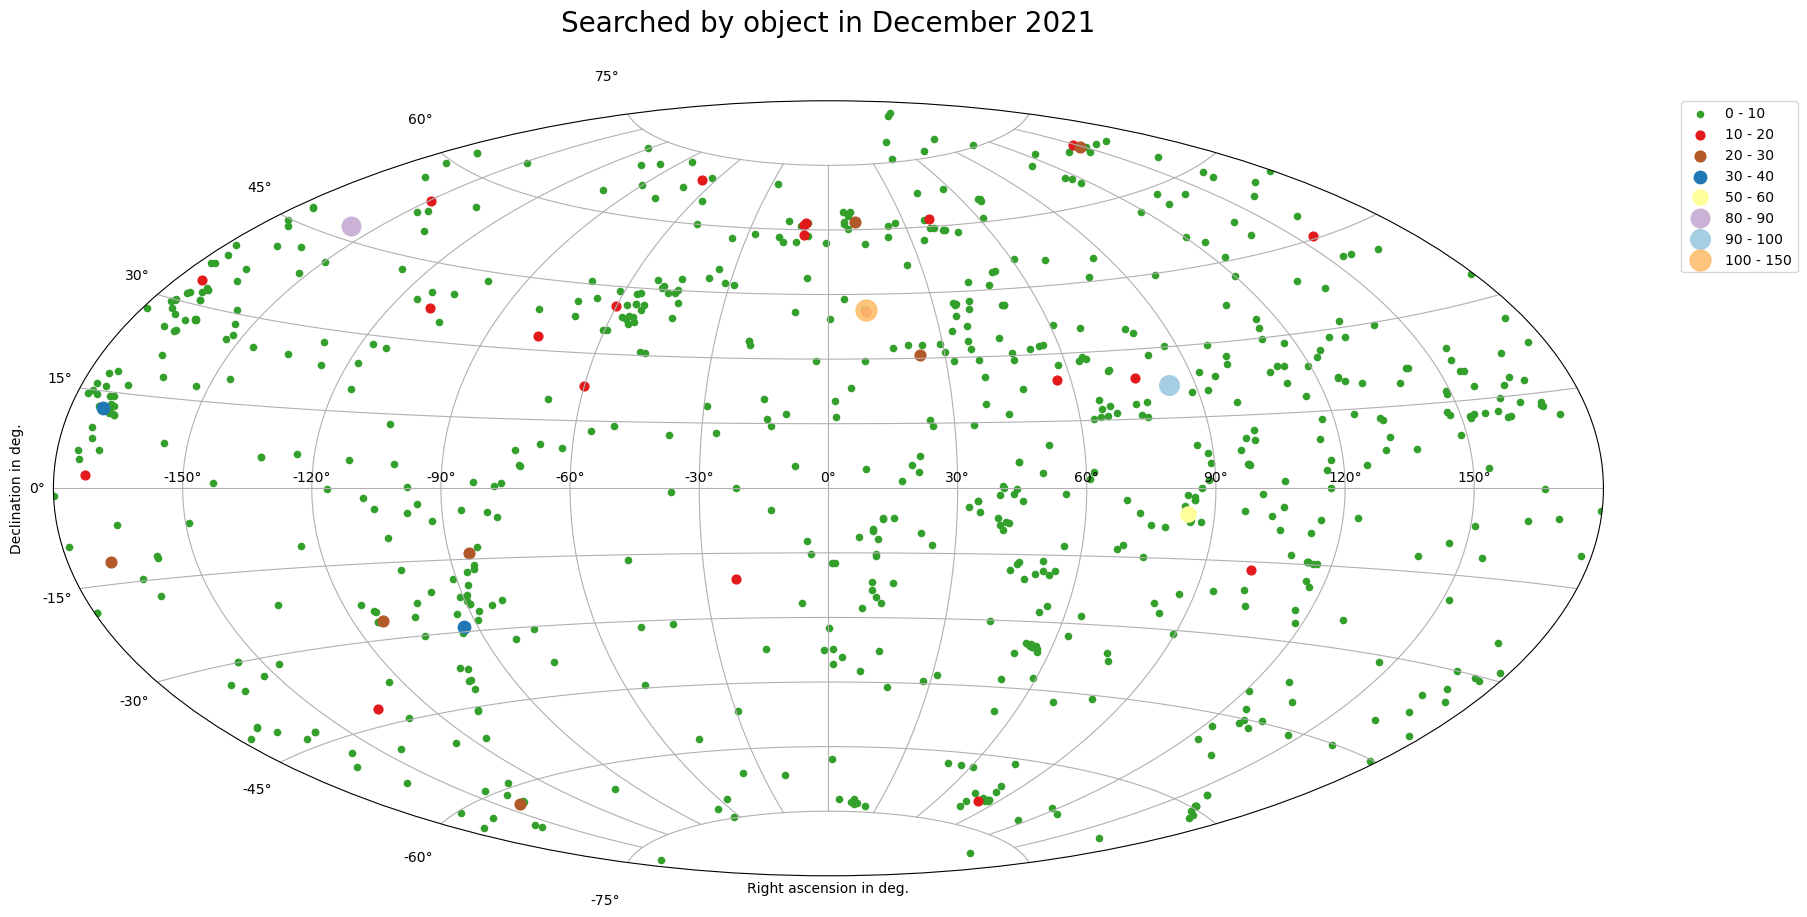

In [7]:
sorted_objects = search_by_object(search_data)
plt.style.use('default')
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection="aitoff") #"aitoff"
col, N = get_color(sorted_objects)  
legend_list=[]
cmap = plt.get_cmap('Paired',N)
groups= sorted_objects.groupby('Number_of_searches')
points=[]
for name, group in groups:
    dec_,ra_ = transformation_for_objects(group.RA,group.DEC)
    num = interval(name)
    alpha,s, label = point_features(num)  # point features
    ax.scatter(ra_.radian, dec_.radian,color=cmap(col.index(num)),s=s, label=label,cmap='Accent',alpha=alpha)

plt.title('Searched by object in {fmonth} {fyear}'.format(fmonth=list_months[month-1],fyear=str(year)), fontsize=20, pad=50)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.xlabel('Right ascension in deg.',fontsize=10)
plt.ylabel('Declination in deg.',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
#save_name = 'Searched_by_object_{fmonth}_{fyear}.png'.format(fmonth=list_months[month-1],fyear=str(year))
#plt.savefig(save_name, bbox_inches='tight',transparent=True, dpi=500)
plt.show()